In [352]:
from matplotlib import pyplot

import numpy as np
import time

%matplotlib inline
%config InlineBackend.figure_format='retina'

import colorsys


In [137]:
dot = np.dot

def solve_2nd_degree(a, b, c): 
    delta = b ** 2 - 4 * a * c
    if delta < 0: 
        return []
    return (
        (-b + np.sqrt(delta)) / (2 * a),
        (-b - np.sqrt(delta)) / (2 * a)
    )

def find_origin(a, b): 
    """ find one point for the line defined by a.x = b"""
    ax, ay = a
    if np.abs(ax) > np.abs(ay): 
        o = np.array([b/ax, 0])
    else: 
        o = np.array([0, b/ay])
    # print(np.dot(o, a) - b)
    return o
    
def norm2(x): 
    return np.dot(x, x)

def norm(x): 
    return np.sqrt(norm2(x))

def contact_3cricle(
        c1, r1, 
        c2, r2,
        r3): 
    """ 
    Find c3 st. (c1, r1), (c2, r2) and (c3, r3) are tangent    
    """
    b = ((r1 + r3)**2 - (r2 + r3)**2 - norm2(c1) + norm2(c2)) / 2
    a = c2 - c1 
    # a.c3 = b
    aorth = np.array([a[1], -a[0]])
    
    o = find_origin(a, b)
        
    # c3 = o + t * aorth, find t
    oprime = o - c1
        
    ts = solve_2nd_degree(
        norm2(aorth), 
        2 * dot(oprime, aorth), 
        norm2(oprime) - (r1 + r3)**2
    )
    
    return [o + t * aorth for t in ts]

def contact_3circle_inside(
        c1, r1, 
        c2, r2, 
        r3): 
    """ 
    Find c3 st. (c1, r1), (c2, r2) and (c3, r3) are tangent
    but c1 and c3 are inside c2, r2.
    """
    b = ((r1 + r3)**2 - (r2 - r3)**2 - norm2(c1) + norm2(c2)) / 2
    a = c2 - c1 
    # a.c3 = b
    aorth = np.array([a[1], -a[0]])
    
    o = find_origin(a, b)
        
    # c3 = o + t * aorth, find t
    oprime = o - c1
        
    ts = solve_2nd_degree(
        norm2(aorth), 
        2 * dot(oprime, aorth), 
        norm2(oprime) - (r1 + r3)**2
    )
    
    return [o + t * aorth for t in ts]


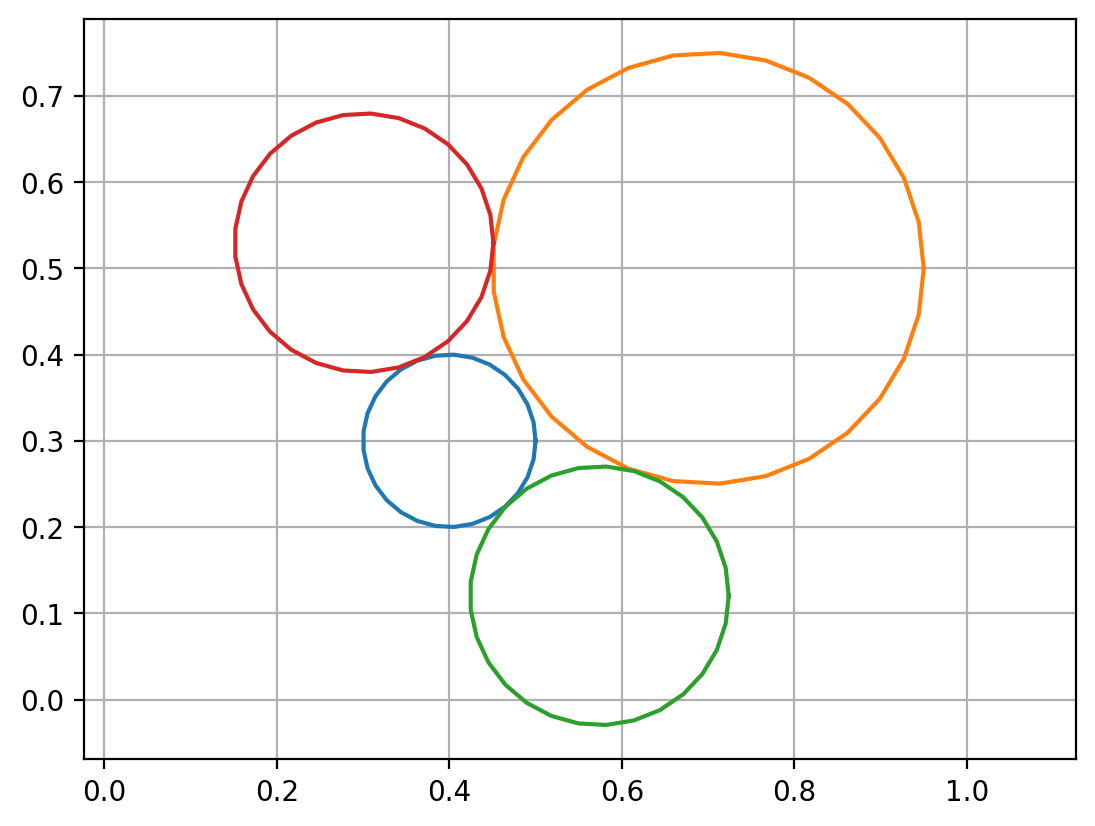

In [102]:
c1 = np.array([0.4, 0.3]); r1 = 0.10
c2 = np.array([0.7, 0.5]); r2 = 0.25
angles = np.linspace(0, 2 * np.pi, 30)
unitcircle = np.vstack([np.cos(angles), np.sin(angles)]).T

xy = c1 + unitcircle * r1
pyplot.plot(xy[:, 0], xy[: ,1])
xy = c2 + unitcircle * r2
pyplot.plot(xy[:, 0], xy[: ,1])


r3 = 0.15
c3s = contact_3cricle(c1, r1, c2, r2, r3)

for c3 in c3s: 
    xy = c3 + unitcircle * r3
    pyplot.plot(xy[:, 0], xy[: ,1])  

pyplot.axis("equal")
pyplot.grid()

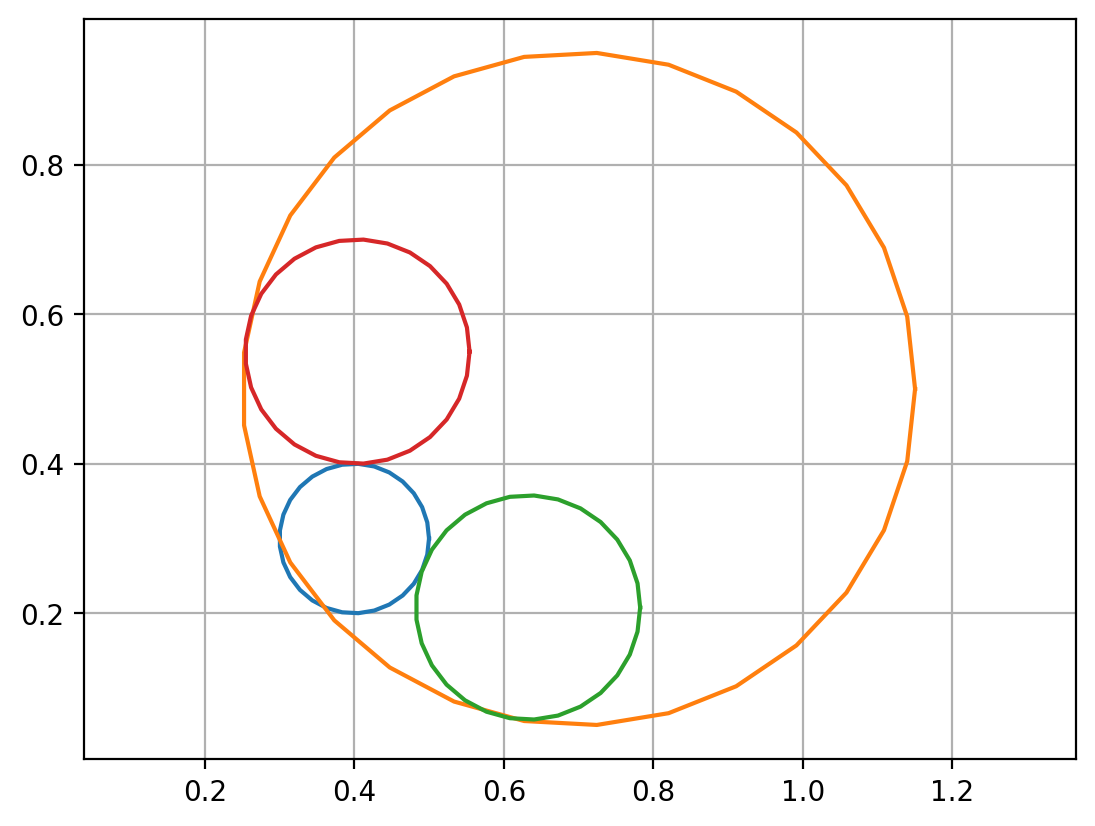

In [115]:
c1 = np.array([0.4, 0.3]); r1 = 0.10
c2 = np.array([0.7, 0.5]); r2 = 0.45
angles = np.linspace(0, 2 * np.pi, 30)
unitcircle = np.vstack([np.cos(angles), np.sin(angles)]).T


xy = c1 + unitcircle * r1
pyplot.plot(xy[:, 0], xy[: ,1])
xy = c2 + unitcircle * r2
pyplot.plot(xy[:, 0], xy[: ,1])


r3 = 0.15
c3s = contact_3circle_inside(c1, r1, c2, r2, r3)

for c3 in c3s: 
    xy = c3 + unitcircle * r3
    pyplot.plot(xy[:, 0], xy[: ,1])  

pyplot.axis("equal")
pyplot.grid()

# Field

In [116]:
# c1 = np.array([0.4, 0.3]); r1 = 0.10
# c2 = np.array([0.7, 0.5]); r2 = 0.25

c1 = np.array([0, 1]); r1 = 1
c2 = np.array([0, -1]); r2 = 1

circles = [(c1, r1), (c2, r2)]


rs = np.random.RandomState(123)
tot1 = tot2 = 0
for i in range(150): 
    r3 = rs.rand() ** 1.5 + 0.05
    nc = len(circles)
    c3s = []
    for j in range(nc):
        c1, r1 = circles[j]
        for k in range(j + 1, nc): 
            c2, r2 = circles[k]
            for c3 in contact_3cricle(c1, r1, c2, r2, r3): 
                # check if intersection with other circles 
                for l in range(nc): 
                    tot1 += 1
                    if l == k or l == j: 
                        continue
                    cl, rl = circles[l]
                    if norm2(c3 - cl) < (rl + r3) ** 2: 
                        break 
                else: 
                    c3s.append(c3)
                    tot2 += 1
    print(f"{i=:} nb c3: {len(c3s)} {tot1=:} {tot2=:}", end="\r", flush=True)
    if False: 
        # pick the c3 that has lowest y
        c3s.sort(key=lambda x: x[1])
    else: 
        # pick the c3 that is closest to 0
        c3s.sort(key=lambda x: norm2(x))
    c3 = c3s[0]
    #print(f"{c3=:}")
    circles.append((c3, r3))
    
        

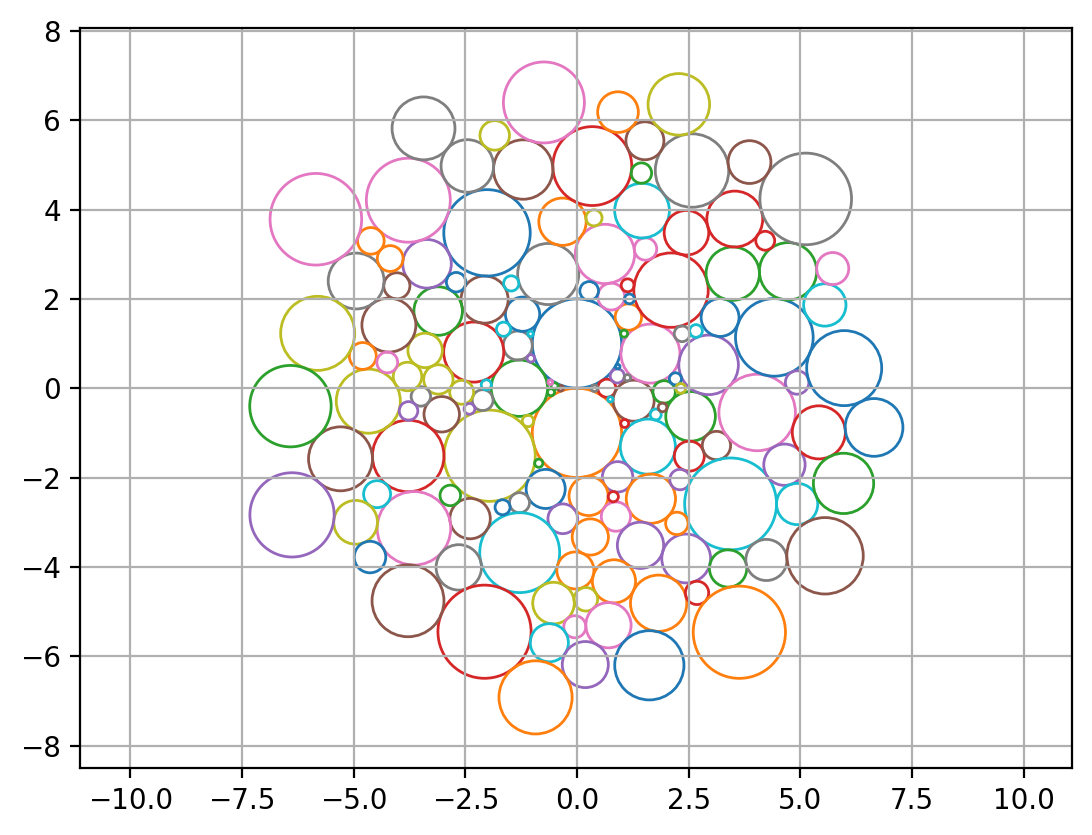

In [121]:
ax = pyplot.gca()
i = 0
for c, r in circles: 
    ax.add_patch(pyplot.Circle(c, r, color='C%d' % i, fill=False))
    i += 1

pyplot.axis("equal")
pyplot.grid()

## Gravity

In [250]:


def generate_cicles_gravity(c0, r0, c1, r1, radiuses): 
    circles = [(c1, r1)]

    tot1 = tot2 = 0
    for i, r3 in enumerate(radiuses): 
        # r3 = 0.25 * rs.rand() ** 3 + 0.01
        nc = len(circles)
        c3s = []
        
        # check contact with great circle 
        for k in range(nc): 
            c2, r2 = circles[k]
            for c3 in contact_3circle_inside(c2, r2, c0, r0, r3): 
                for l in range(nc): 
                    tot1 += 1
                    if l == k: 
                        continue
                    cl, rl = circles[l]
                    if norm2(c3 - cl) < (rl + r3) ** 2: 
                        break 
                else: 
                    c3s.append(c3)
                    tot2 += 1

        for j in range(nc):
            c1, r1 = circles[j]
            for k in range(j + 1, nc): 
                c2, r2 = circles[k]
                for c3 in contact_3cricle(c1, r1, c2, r2, r3): 
                    # check if intersection with other circles 
                    for l in range(nc): 
                        tot1 += 1
                        if l == k or l == j: 
                            continue
                        cl, rl = circles[l]
                        if norm2(c3 - cl) < (rl + r3) ** 2: 
                            break 
                    else: 
                        if norm(c0 - c3) + r3 < r0: 
                            c3s.append(c3)
                            tot2 += 1
        if len(c3s) == 0: 
            continue
        if True: 
            # pick the c3 that has lowest y
            c3s.sort(key=lambda x: x[1])
        else: 
            # pick the c3 that is closest to 0
            c3s.sort(key=lambda x: norm2(x))
        c3 = c3s[0]
        #print(f"{c3=:}")
        circles.append((c3, r3))
        print(f"{i=:} nb circles: {len(circles)} "
              f"nb c3: {len(c3s)} {tot1=:} {tot2=:}", end="\r", flush=True)

    return circles
        

## Explore powers 

p= 1
i=243 nb circles: 50 nb c3: 6 tot1=595161 tot2=202317


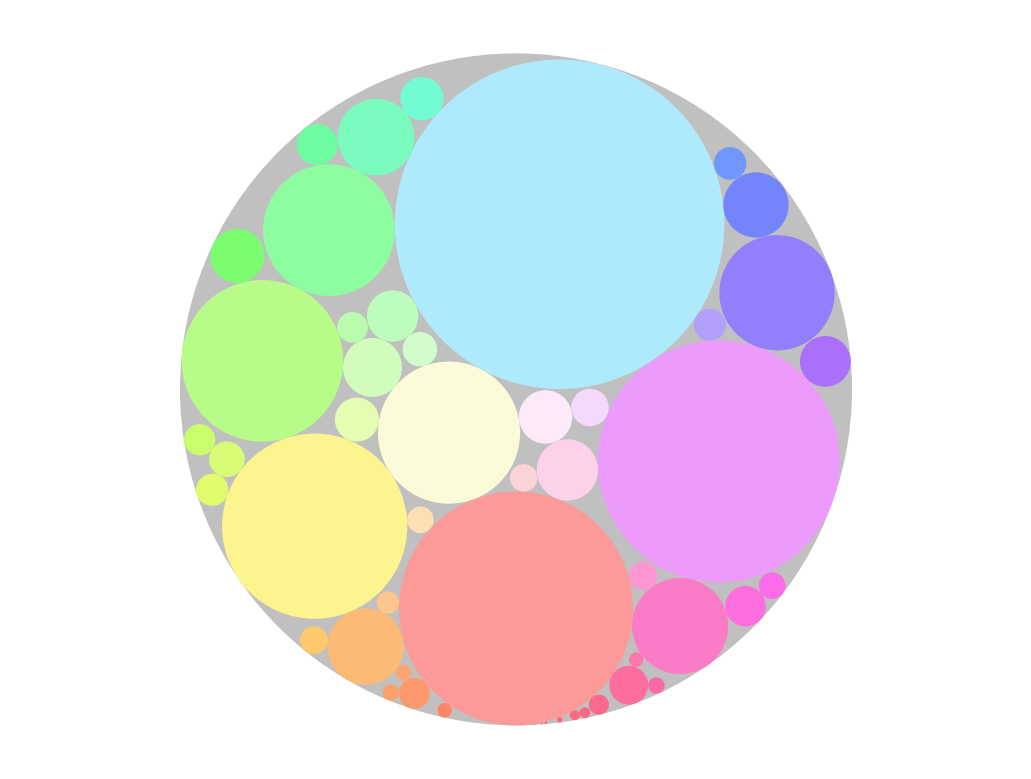

p= 2
i=243 nb circles: 105 nb c3: 304 tot1=3186952 tot2=11860


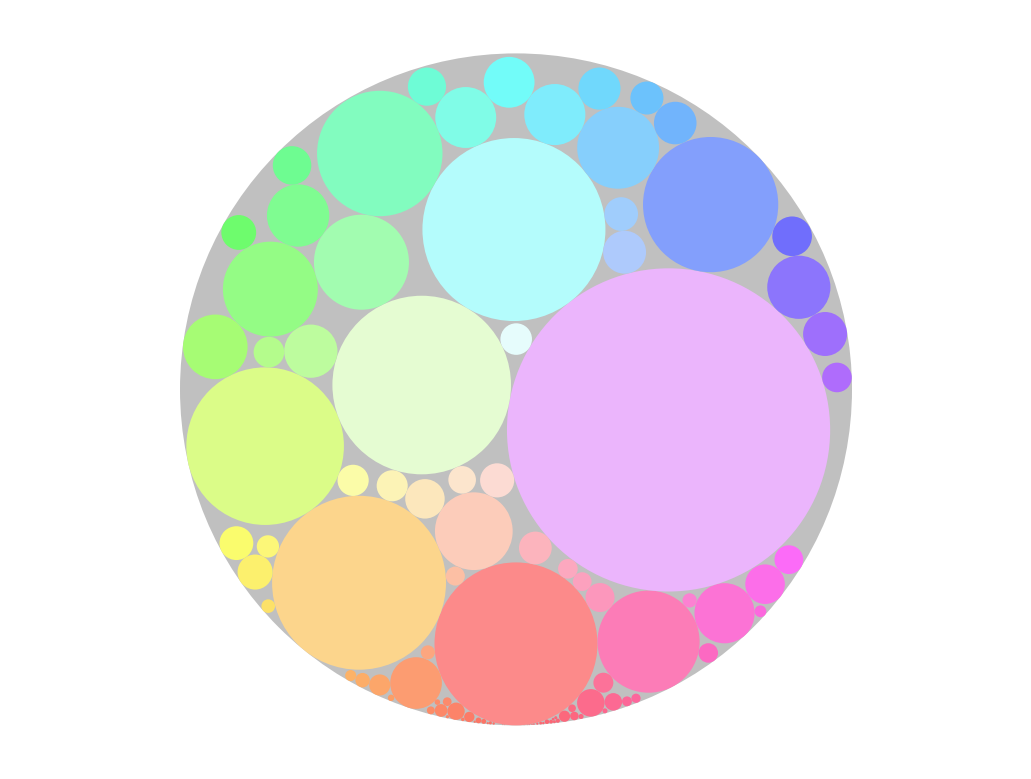

p= 3
i=246 nb circles: 149 nb c3: 136 tot1=7105283 tot2=23574


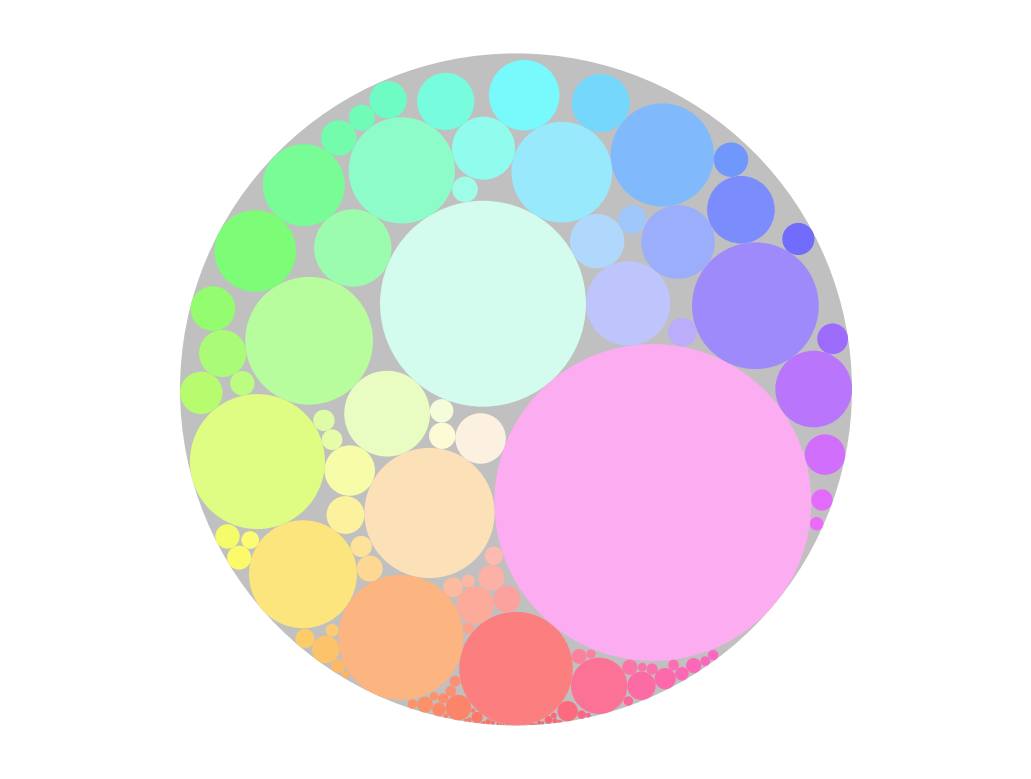

p= 5
i=246 nb circles: 199 nb c3: 429 tot1=12291825 tot2=39972


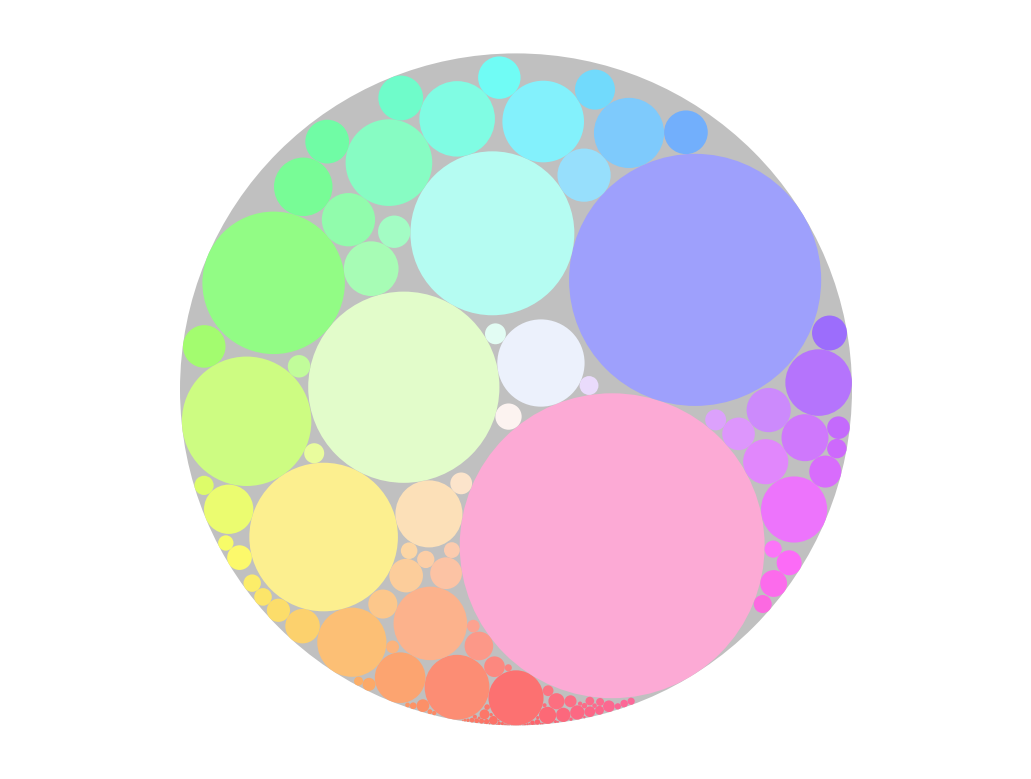

p= 8
i=246 nb circles: 223 nb c3: 574 tot1=15256741 tot2=49575


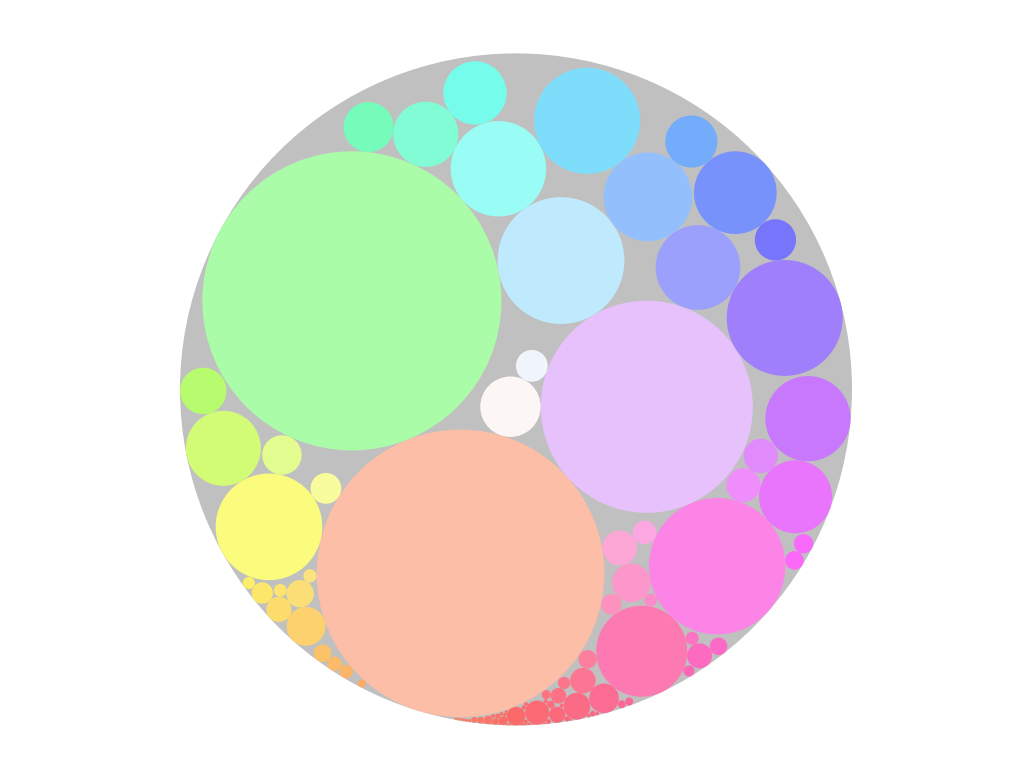

In [272]:
c0 = np.array([0, 0]); r0 = 1
c2 = np.array([0, -0.7]); r2 = 0.3
# minsize = 0.01

for p in 1, 2, 3, 5, 8:
    print("p=", p)

    rs = np.random.RandomState(123)

    radiuses = [0.5 * rs.rand() ** p for _ in range(250)]
    # radiuses.sort(reverse=True)
    #print(radiuses)
    r0 = radiuses[0]
    circles = generate_cicles_gravity(
        np.array([0, 0]), 1,
        np.array([0, -1 + r0]), r0,
        radiuses[1:]
    )

    print()

    ax = pyplot.gca()
    # pyplot.gcf().set_size_inches(7, 10)
    pyplot.axis('off')

    ax.add_patch(pyplot.Circle((0, 0), 1, color="#c0c0c0", fill=True, linewidth=0))

    for c, r in circles: 
        x, y = c 
        rho, theta = np.hypot(x, y), np.arctan2(x, y)
        color = colorsys.hsv_to_rgb(
            (theta / (2 * np.pi) + 0.5) % 1, 
            0.6 * rho, 
            0.99
        )
        ax.add_patch(pyplot.Circle(c, r, color=color, fill=True, linewidth=0))

    pyplot.axis("equal")
    pyplot.show()

# Recursive 

In [273]:
rs = np.random.RandomState(123)

all_circles = []

for i in range(5): 
    print("run", i)
    radiuses = [0.5 * rs.rand() ** 3 for _ in range(250)]
    # radiuses.sort(reverse=True)
    #print(radiuses)
    r0 = radiuses[0]
    circles = generate_cicles_gravity(
        np.array([0, 0]), 1,
        np.array([0, -1 + r0]), r0,
        radiuses[1:]
    )
    all_circles.append(circles)

run 0
run 1 nb circles: 149 nb c3: 136 tot1=7105283 tot2=23574
run 2 nb circles: 158 nb c3: 28 tot1=7090254 tot2=224124
run 3 nb circles: 133 nb c3: 252 tot1=5366238 tot2=18279
run 4 nb circles: 163 nb c3: 218 tot1=7189812 tot2=23503


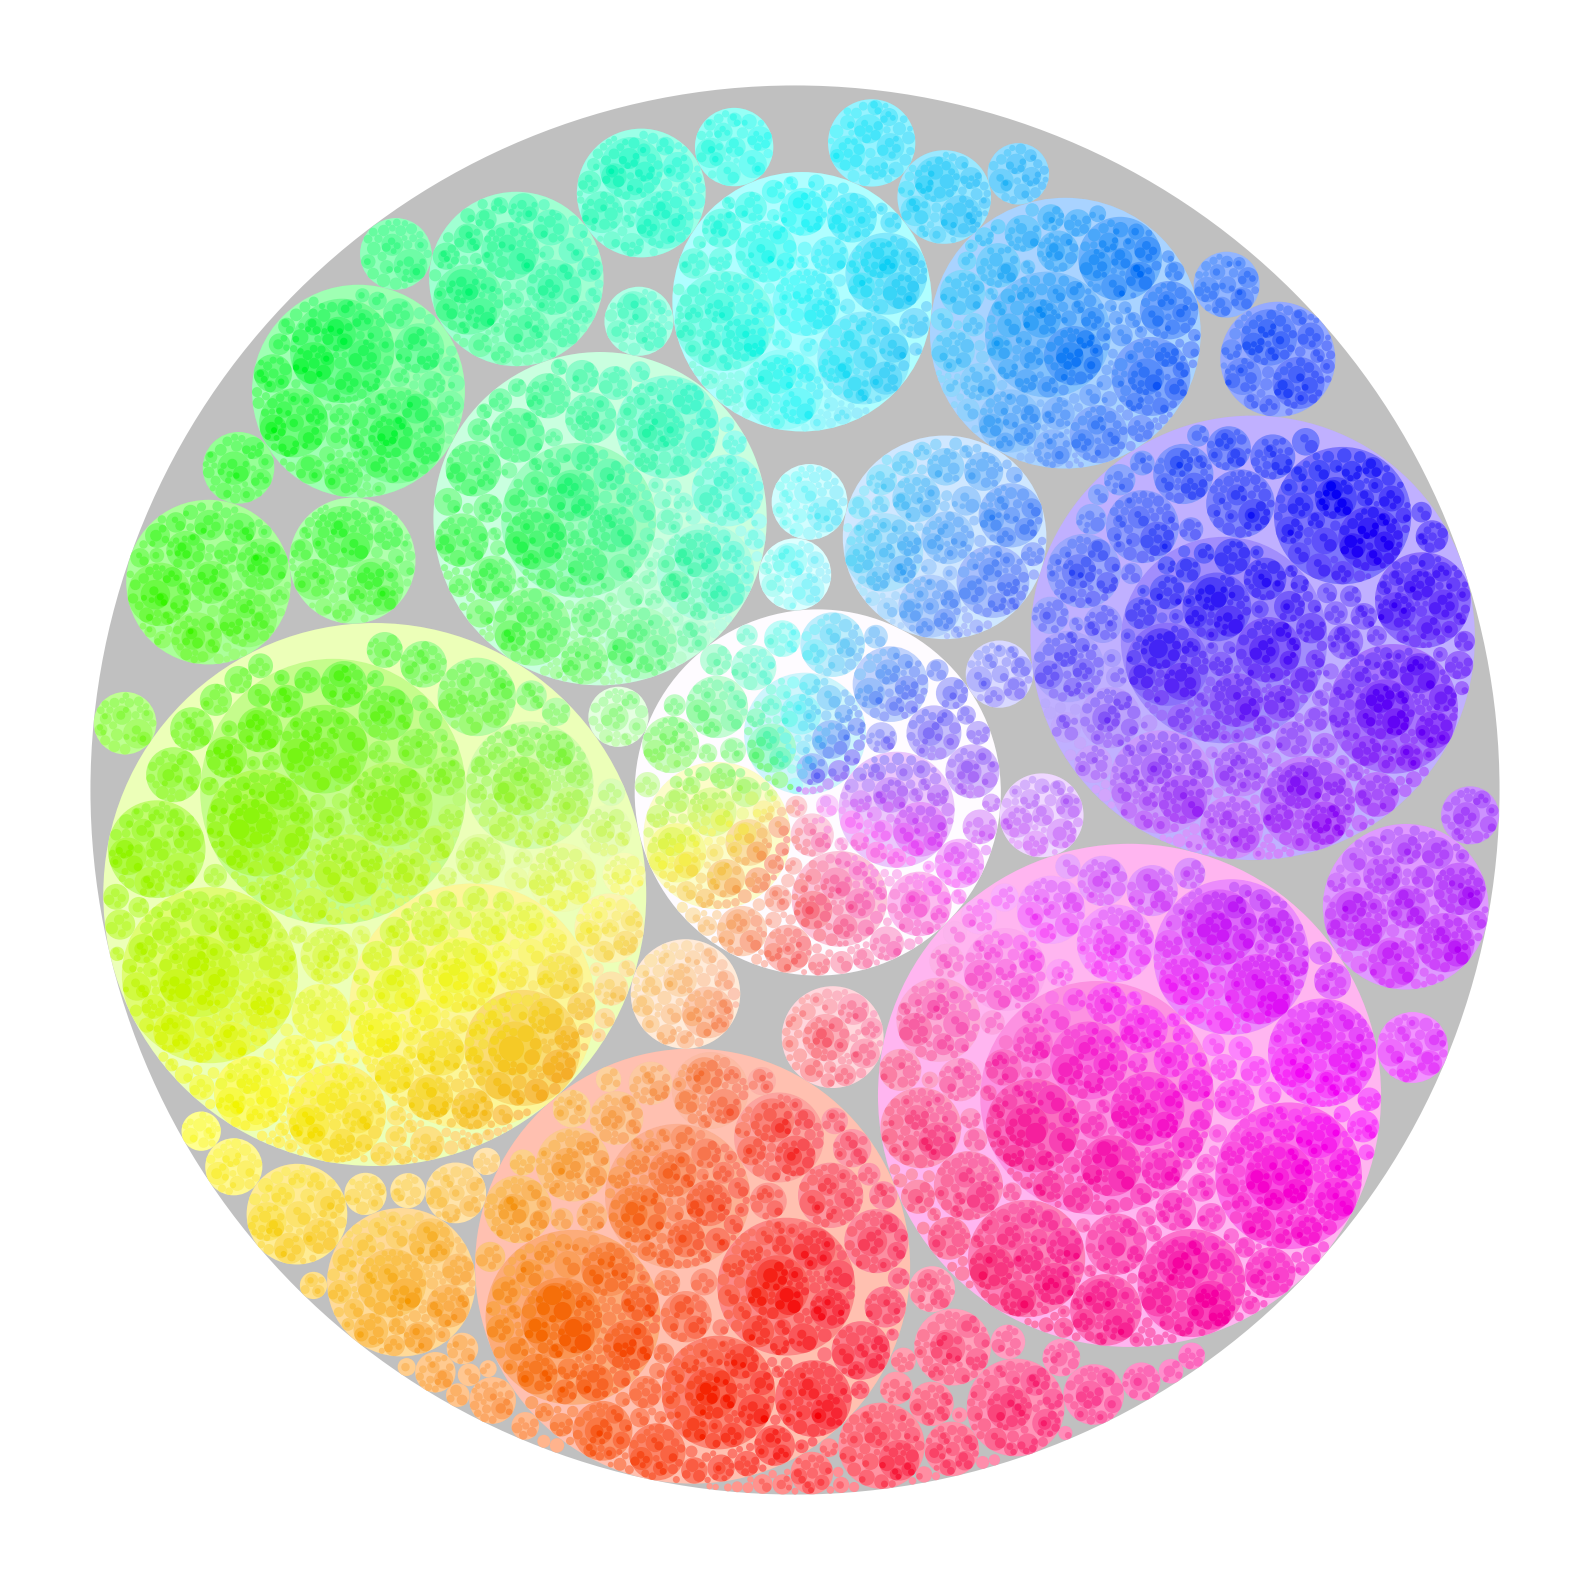

In [277]:

ax = pyplot.gca()
pyplot.gcf().set_size_inches(10, 10)
pyplot.axis('off')

ax.add_patch(pyplot.Circle((0, 0), 1, color="#c0c0c0", fill=True, linewidth=0))
minsize = 0.004

rs = np.random.RandomState(123)

def rec_add_patches(depth, co, ro): 
    #print(depth, co, ro)
    circles = all_circles[rs.randint(len(all_circles))]
    for c, r in circles: 
        c = co + c * ro
        r = r * ro
        if r < minsize: 
            continue
        x, y = c 
        rho, theta = np.hypot(x, y), np.arctan2(x, y)
        h = theta / (2 * np.pi) + 0.5
        s = np.clip(0.45 * rho + depth * 0.15, 0, 1)
        v = 0.99 ** depth
        
        color = colorsys.hsv_to_rgb(h, s, v)
        
        ax.add_patch(pyplot.Circle(c, r, color=color, fill=True, linewidth=0))
        
        color2 = colorsys.hsv_to_rgb(h, s, v / 2)
        ax.add_patch(pyplot.Circle(c, r, color=color2, fill=False, linewidth=0.001))

        
        if depth < 4: 
            rec_add_patches(depth + 1, c, r)

rec_add_patches(0, np.zeros(2), 1.0)

pyplot.axis("equal")
pyplot.savefig("test2.pdf")


(-1.1, 1.1, -1.1, 1.1)

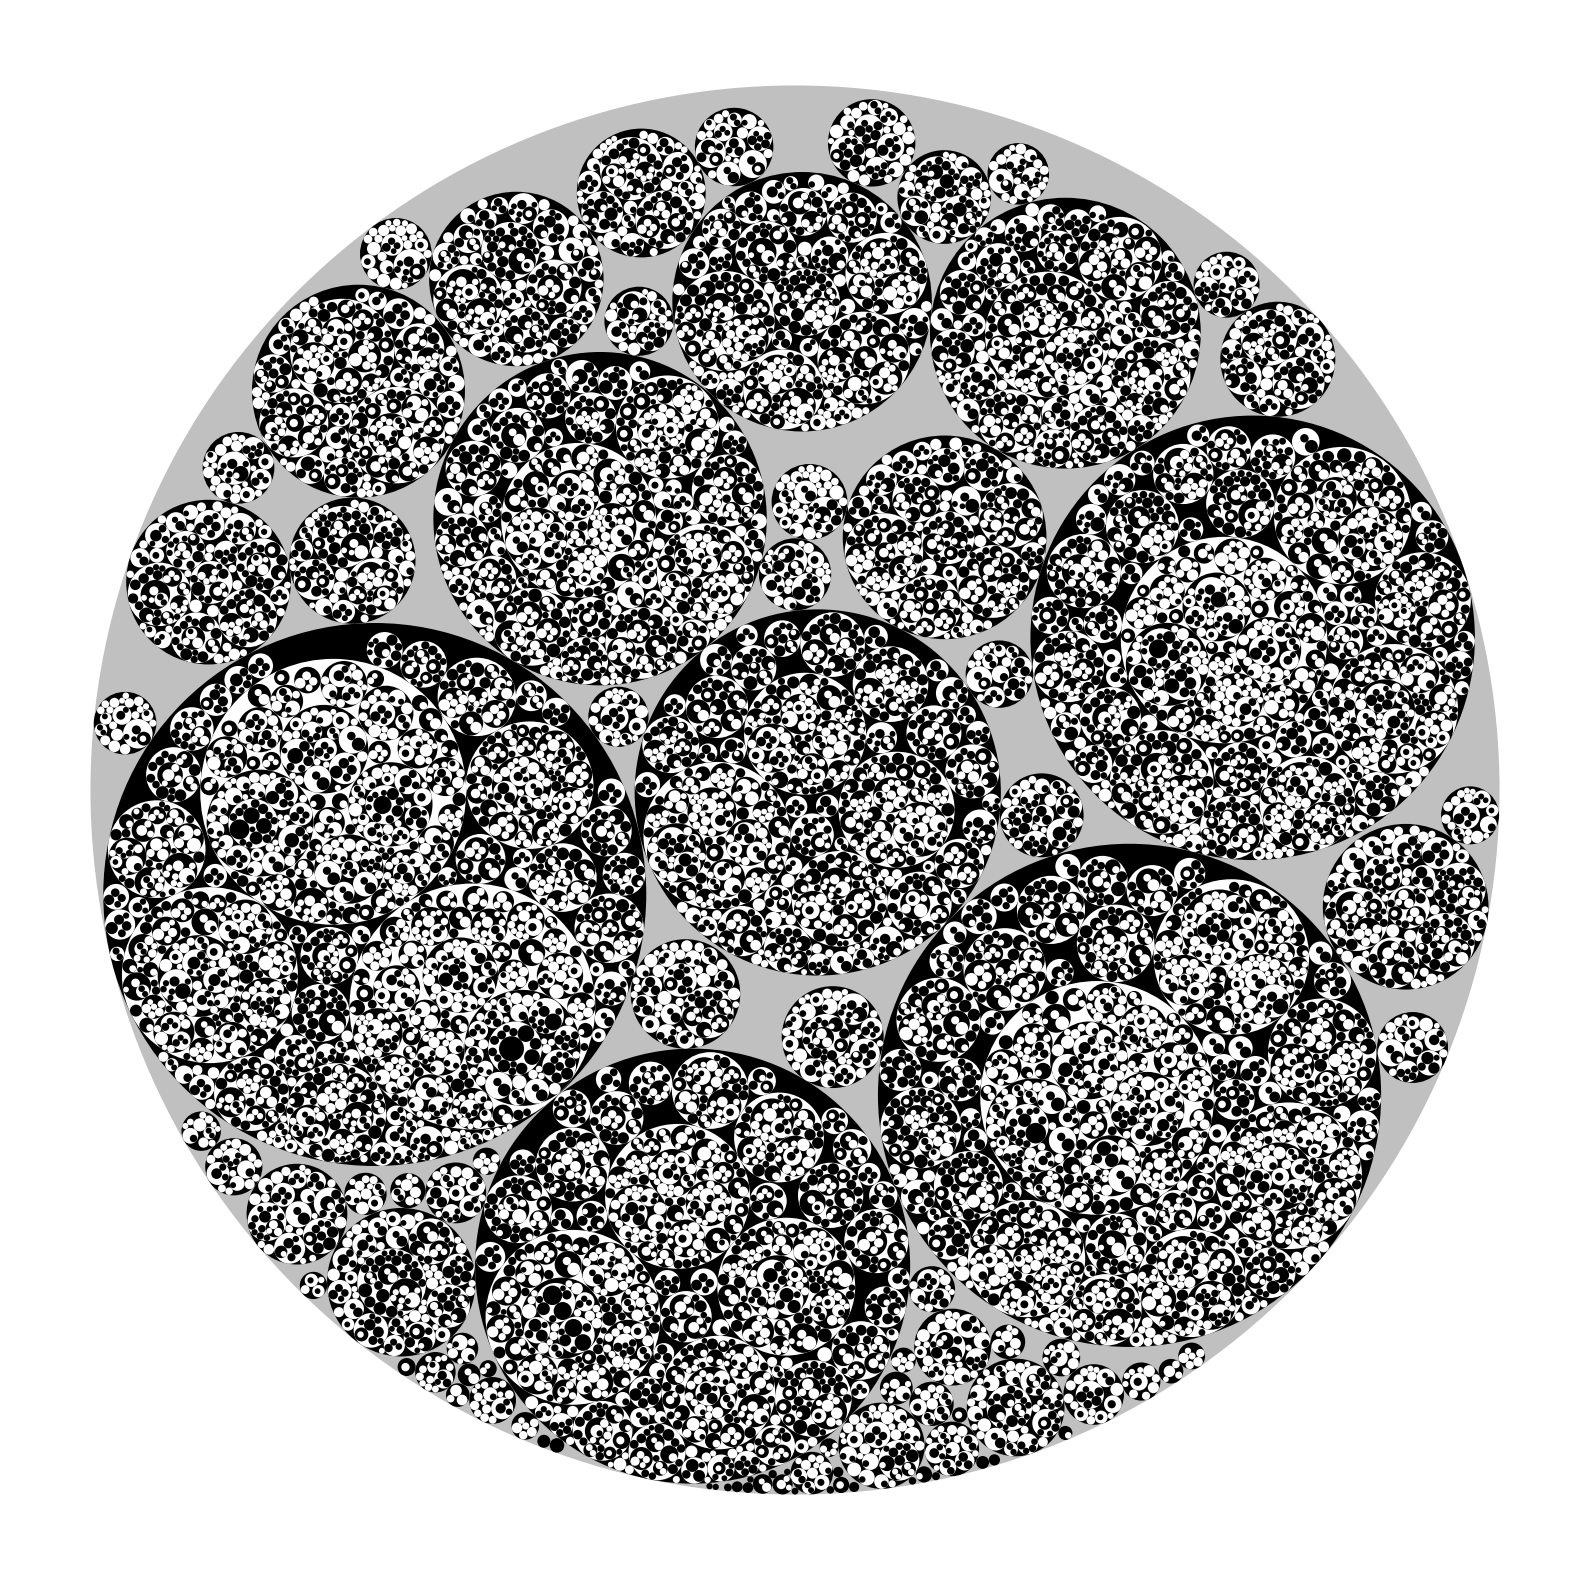

In [276]:

ax = pyplot.gca()
pyplot.gcf().set_size_inches(10, 10)
pyplot.axis('off')

ax.add_patch(pyplot.Circle((0, 0), 1, color="#c0c0c0", fill=True, linewidth=0))
minsize = 0.004

rs = np.random.RandomState(123)

def rec_add_patches(depth, co, ro): 
    #print(depth, co, ro)
    circles = all_circles[rs.randint(len(all_circles))]
    for c, r in circles: 
        c = co + c * ro
        r = r * ro
        if r < minsize: 
            continue
        x, y = c 
        rho, theta = np.hypot(x, y), np.arctan2(x, y)
        
        color = "black" if depth % 2 == 0 else "white"
        
        ax.add_patch(pyplot.Circle(c, r, color=color, fill=True, linewidth=0))
        
        if depth < 4: 
            rec_add_patches(depth + 1, c, r)

rec_add_patches(0, np.zeros(2), 1.0)

pyplot.axis("equal")

## KDtree 

In [396]:
        
def intersect_range(amin, amax, bmin, bmax): 
    return not(bmax < amin or amax < bmin)


def circle_intersects_bbox(circle, bbox): 
    c, r = circle 
    x, y = c
    xmin, ymin, xmax, ymax = bbox
    # horizontal intersect 
    if x + r < xmin: 
        return False
    elif x < xmin: 
        yo = np.sqrt(r ** 2 - (xmin - x) ** 2)
        return intersect_range(y - yo, y + yo, ymin, ymax)
    elif x < xmax: 
        return intersect_range(y - r, y + r, ymin, ymax)
    elif x - r < xmax: 
        yo = np.sqrt(r ** 2 - (x - xmax) ** 2)
        return intersect_range(y - yo, y + yo, ymin, ymax)
    else: 
        return False        


def filter_with_bbox(circles, bbox):                     
    return list(filter(
        lambda circle: circle_intersects_bbox(circle, bbox), 
        circles
    ))

max_per_leaf = 10

class Node: 
    
    def __init__(self, bbox, path, circles=None): 
        self.bbox = bbox
        self.path = path
        self.is_leaf = True
        self.circles = circles if circles else []

    def surface(self): 
        xmin, ymin, xmax, ymax = self.bbox
        return (xmax - xmin) * (ymax - ymin)
        
    def split(self): 
        xmin, ymin, xmax, ymax = self.bbox
        if xmax - xmin > ymax - ymin: 
            # split vertically
            xmid = (xmin + xmax) / 2 
            bbox1 = (xmin, ymin, xmid, ymax)
            bbox2 = (xmid, ymin, xmax, ymax)
        else: 
            # split horizontally
            ymid = (ymin + ymax) / 2 
            bbox1 = (xmin, ymin, xmax, ymid)
            bbox2 = (xmin, ymid, xmax, ymax)
        circles = self.circles 
        del self.circles 
        
        self.child1 = Node(bbox1, self.path + "1", filter_with_bbox(circles, bbox1))
        self.child2 = Node(bbox2, self.path + "2", filter_with_bbox(circles, bbox2))
        
        self.is_leaf = False

    def add_circle(self, circle): 
        if not circle_intersects_bbox(circle, self.bbox): 
            return 
        if self.is_leaf: 
            self.circles.append(circle)
            if len(self.circles) > max_per_leaf: 
                self.split()
        else: 
            self.child1.add_circle(circle)
            self.child2.add_circle(circle)
    

In [398]:
root = Node((-1, -1, 1, 1), path="")

for circle in circles:
    root.add_circle(circle)

In [357]:
str(circle)

'(array([ 0.00200651, -0.99991882]), 7.916521697962156e-05)'

In [358]:
def check_consistent(root, circles): 
    if root.is_leaf:
        set1 = set()        
        for circle in root.circles: 
            if circle_intersects_bbox(circle, root.bbox): 
                set1.add(str(circle))
        set2 = set()
        for circle in circles: 
            if circle_intersects_bbox(circle, root.bbox): 
                set2.add(str(circle))
        assert set1 == set2
    else: 
        check_consistent(root.child1, circles)
        check_consistent(root.child2, circles)

check_consistent(root, circles)

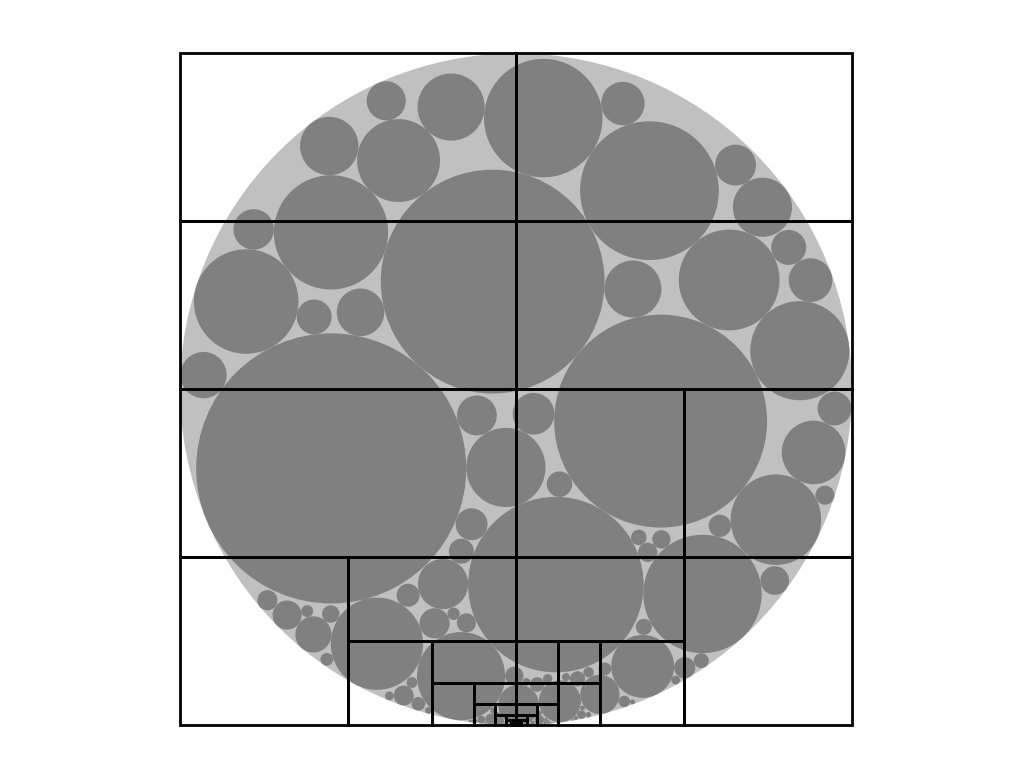

In [359]:

ax = pyplot.gca()
# pyplot.gcf().set_size_inches(7, 10)
pyplot.axis('off')

ax.add_patch(pyplot.Circle((0, 0), 1, color="#c0c0c0", fill=True, linewidth=0))

for c, r in circles: 
    x, y = c 
    ax.add_patch(pyplot.Circle(c, r, color="gray", fill=True, linewidth=0))

def draw_tree(root): 
    if root.is_leaf: 
        xmin, ymin, xmax, ymax = root.bbox
        ax.add_patch(pyplot.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin, 
            fill=False
        ))
    else: 
        draw_tree(root.child1)
        draw_tree(root.child2)
    
draw_tree(root)
    
pyplot.axis("equal")
pyplot.show()

In [430]:
def range_distance(amin, amax, bmin, bmax): 
    if amax < bmin: 
        return bmin - amax
    if bmax < amin:
        return amin - bmax
    # the ranges intersect
    return 0

def nearest_corner(bbox, xy): 
    """ find nearest corner of the bbox w.r.t. xy"""
    x, y = xy
    xmin, ymin, xmax, ymax = bbox
    return (
        xmin if x < (xmin + xmax) / 2 else xmax, 
        ymin if y < (ymin + ymax) / 2 else ymax
    )

def bbox_distance(bbox1, bbox2): 
    """ minimum distance between contents of 2 bounding boxes """
    xmin1, ymin1, xmax1, ymax1 = bbox1
    xmin2, ymin2, xmax2, ymax2 = bbox2

    dy = range_distance(ymin1, ymax1, ymin2, ymax2)
    dx = range_distance(xmin1, xmax1, xmin2, xmax2)

    if dx != 0 and dy != 0: 
        # then it is a corner-wise distance 
        # find which corner... 
        x1, y1 = nearest_corner(bbox1, (xmin2, ymin2))
        x2, y2 = nearest_corner(bbox2, (xmin1, ymin1))
        return np.hypot(x1 - x2, y1 - y2)        
    else: 
        return max(dx, dy)
    
    


In [434]:


def enumerate_pairs_2(root1, root2, distance, pref=""): 
    " yield pairs of leaves such that the min distance between leave bbox is < distance"
    
    # check if the nodes are close enough
    d = bbox_distance(root1.bbox, root2.bbox)
    
    if d > distance: 
        return 
    #print(pref, end='\r', flush=True)
    #time.sleep(0.02)
    
    if root1.is_leaf and root2.is_leaf: 
        yield root1, root2
    elif root1.is_leaf: 
        yield from enumerate_pairs_2(root1, root2.child1, distance, pref+"D")
        yield from enumerate_pairs_2(root1, root2.child2, distance, pref+"E")
    elif root2.is_leaf:
        yield from enumerate_pairs_2(root1.child1, root2, distance, pref+"A")
        yield from enumerate_pairs_2(root1.child2, root2, distance, pref+"B")
    else: 
        yield from enumerate_pairs_2(root1.child1, root2.child1, distance, pref+"F")
        yield from enumerate_pairs_2(root1.child1, root2.child2, distance, pref+"G")
        yield from enumerate_pairs_2(root1.child2, root2.child1, distance, pref+"H")
        yield from enumerate_pairs_2(root1.child2, root2.child2, distance, pref+"I")
        
            
def enumerate_pairs(root, dis, pref=""): 
    if root.is_leaf: 
        return 
    else:         
        yield from enumerate_pairs_2(root.child1, root.child2, dis, pref=pref+"/")
        yield from enumerate_pairs(root.child1, dis, pref=pref+"1")
        yield from enumerate_pairs(root.child2, dis, pref=pref+"2")
            
            
def enumerate_leaves(root): 
    if root.is_leaf: 
        yield root
    else: 
        yield from enumerate_leaves(root.child1)
        yield from enumerate_leaves(root.child2)
        

In [435]:
dis = 0.012

ref = {}

print("REF")
i = 0
for leaf1 in enumerate_leaves(root):
    print("leaf", i, end='\r', flush=True)
    i += 1
    for leaf2 in enumerate_leaves(root):       
        if leaf1 != leaf2 and bbox_distance(leaf1.bbox, leaf2.bbox) < dis: 
            # print(leaf1, leaf2)
            x = [str(leaf1), str(leaf2)]
            x.sort()
            ref[tuple(x)] = (leaf1, leaf2)
print()
            
new = {}
print("NEW")

for leaf1, leaf2 in enumerate_pairs(root, dis): 
    if bbox_distance(leaf1.bbox, leaf2.bbox) < dis:
        x = [str(leaf1), str(leaf2)]
        x.sort()
        new[tuple(x)] = (leaf1, leaf2)

print()
     

REF
leaf 52
NEW



In [436]:
len(ref), len(new)

(358, 358)

In [429]:
for k in ref.keys() - new.keys(): 
    leaf1, leaf2 = ref[k]
    print(leaf1.path, leaf2.path,  bbox_distance(leaf1.bbox, leaf2.bbox))

In [407]:
node_tab = {}
def rec_mk_tab(root): 
    node_tab[root.path] = root
    if not root.is_leaf: 
        rec_mk_tab(root.child1)
        rec_mk_tab(root.child2)
rec_mk_tab(root)

In [410]:
bbox_distance(
    node_tab["1112121212122"].bbox, 
    node_tab["1112121212121211"].bbox
)

0.017469281074217108

In [412]:
bbox_distance(
    node_tab["1112121212121211"].bbox,
    node_tab["1112121212122"].bbox, 
)

0.0078125

In [415]:
node_tab["1112121212121211"].bbox, node_tab["1112121212122"].bbox

((-0.015625, -1, -0.0078125, -0.9921875), (-0.03125, -0.984375, 0.0, -0.96875))

In [ ]:
1112121212122 
1112121212121211 

1112121212122 
11121212121212122 

1112121212122 
111212121212121211 
111212121212121


# Rebut

In [318]:
1+2

3

In [426]:
# unit test for bbox distance

rs = np.random.RandomState(456)

def random_bbox(): 
    xmin, xmax, ymin, ymax = rs.rand(4) 
    if xmax < xmin: 
        xmin, xmax = xmax, xmin
    if ymax < ymin: 
        ymin, ymax = ymax, ymin
    return (xmin, ymin, xmax + 0.1, ymax + 0.1)        


def plot_bbox(bbox): 
    xmin, ymin, xmax, ymax = bbox
    pyplot.gca().add_patch(
        pyplot.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, color=np.random.rand(3))    
    )
    

for a in range(50): 
    bbox1 = random_bbox()
    bbox2 = random_bbox()
    # plot_bbox(bbox1)
    # plot_bbox(bbox2)
    d12 = bbox_distance(bbox1, bbox2)
    d21 = bbox_distance(bbox2, bbox1)
    print(bbox1, bbox2, d12, d21)
    np.testing.assert_almost_equal(d12, d21)
    #pyplot.grid()
    #pyplot.axis("equal")
    #pyplot.show()


AA: 0.2553577239183221 0
AA: 0.2553577239183221 0
(0.16306678318635648, 0.7836432556412277, 0.34875590935710177, 0.9085233888414788) (0.6041136332754239, 0.7591174678329832, 0.7256284278232958, 0.9857019031149136) 0.2553577239183221 0.2553577239183221
AA: 0 0
AA: 0 0
(0.1501693161428389, 0.38527255265008964, 0.28110505614124404, 0.5356793711439582) (0.14609069445663325, 0.46880400506122877, 0.6757098698077493, 0.7865930187051551) 0 0
AA: 0.289082008262172 0.3379363644451926
AA: 0.289082008262172 0.3379363644451926
(0.5699991476659645, 0.6806707599795607, 0.7457010148048536, 0.8233406440863501) (0.1181584834964634, 0.008183416121430698, 0.2809171394037925, 0.34273439553436813) 0.44471270941510604 0.44471270941510604
AA: 0 0
AA: 0 0
(0.1460417453061661, 0.5427230570313438, 0.46006849771133485, 0.9571034377480242) (0.13463345870123333, 0.21359356064866952, 0.3002121645848741, 1.0731556538429636) 0 0
AA: 0 0
AA: 0 0
(0.5337853219096339, 0.18719256650424365, 0.9583297869224262, 0.5344585909